In [1]:
import numpy as np
import pandas as pd

/Users/adi/.pyenv/versions/3.10.4/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = np.load("spmm_benchmarking.npy")

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt # Import matplotlib for plotting
import xgboost as xgb # Import xgboost


# Separate features (X) and output (y)
# Original features: NNZ, M, K, N
X_original = np.array([d[:4] for d in data])
y = np.array([d[4] for d in data])

# Function to generate additional and non-linear features
def generate_features(nnz, m, k, n):
    features = []
    # Original features are added later

    # Existing generated features
    features.append(2 * nnz * n)
    features.append(2 * nnz * n / m if m != 0 else 0)
    features.append(nnz / (m * k) if m * k != 0 else 0)
    features.append(m * k)
    features.append(k * n)
    features.append(m * n)
    features.append(m / k if k != 0 else 0)
    features.append(k / n if n != 0 else 0)
    features.append(m / n if n != 0 else 0)
    denominator = 2 * nnz * n
    numerator = (nnz * 4 + m * 8 + nnz * 8) + (k * n * 4) + (m * n * 4)
    features.append(numerator / denominator if denominator != 0 else 0)

    # --- Added Non-linear Features ---
    # Squares of original features
    features.append(nnz**2)
    features.append(m**2)
    features.append(k**2)
    features.append(n**2)

    # Cubes of original features (added as requested)
    features.append(nnz**3)
    features.append(m**3)
    features.append(k**3)
    features.append(n**3)


    # Additional interaction terms
    features.append(nnz * m)
    features.append(k * m)
    features.append(nnz * k)
    features.append(nnz * m * k) # Example of a higher-order interaction

    # Logarithmic transformations (handle zero values by adding a small constant or checking)
    features.append(np.log(nnz) if nnz > 0 else 0)
    features.append(np.log(m) if m > 0 else 0)
    features.append(np.log(k) if k > 0 else 0)
    features.append(np.log(n) if n > 0 else 0)
    # --- End of Added Non-linear Features ---


    return features

# Generate all features for each data point (original + generated + non-linear)
# We will combine original features later after potential removal
X_generated_nonlinear = np.array([generate_features(d[0], d[1], d[2], d[3]) for d in data])

# Combine original features with generated and non-linear features for correlation calculation
# This is a temporary combination to calculate correlations
X_combined_all = np.hstack((X_original, X_generated_nonlinear))

# Create feature names for clarity
original_feature_names = ['NNZ', 'M', 'K', 'N']
generated_feature_names = [
    '2*NNZ*N', '2*NNZ*N/M', 'NNZ/(M*K)', 'M*K', 'K*N', 'M*N', 'M/K', 'K/N', 'M/N',
    '((NNZ*4+M*8+NNZ*8)+(K*N*4)+(M*N*4))/(2*NNZ*N)'
]
nonlinear_feature_names = [
    'NNZ^2', 'M^2', 'K^2', 'N^2',
    'NNZ^3', 'M^3', 'K^3', 'N^3', # Added cubic feature names
    'NNZ*M', 'K*M', 'NNZ*K', 'NNZ*M*K',
    'log(NNZ)', 'log(M)', 'log(K)', 'log(N)'
]
all_feature_names = original_feature_names + generated_feature_names + nonlinear_feature_names


# --- Outlier Removal Option ---
# Set this flag to True to remove outliers based on the IQR of the target variable (y)
REMOVE_OUTLIERS = True

if REMOVE_OUTLIERS:
    print("Attempting to remove outliers...")
    # Calculate IQR for the target variable (y)
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Create a boolean mask for data points within the bounds
    non_outlier_mask = (y >= lower_bound) & (y <= upper_bound)

    # Apply the mask to filter both features and target variable
    X_combined_filtered_outliers = X_combined_all[non_outlier_mask]
    y_filtered_outliers = y[non_outlier_mask]

    print(f"Original data points: {len(y)}")
    print(f"Data points after outlier removal: {len(y_filtered_outliers)}")

    # Use filtered data for subsequent steps
    X_for_correlation = X_combined_filtered_outliers
    y_for_correlation = y_filtered_outliers
else:
    # Use original data if not removing outliers
    X_for_correlation = X_combined_all
    y_for_correlation = y


# --- Feature Correlation Removal Option ---
# Set this flag to True to remove features with low absolute correlation to the target variable
REMOVE_LOW_CORRELATION_FEATURES = True
# Set the absolute correlation threshold below which features will be considered for removal
CORRELATION_THRESHOLD = 0.1 # Example threshold, adjust as needed

# Store the names of features to keep
features_to_keep_names = []
# Store the indices of features to keep
features_to_keep_indices = []

if REMOVE_LOW_CORRELATION_FEATURES:
    print(f"\nAttempting to remove features with absolute correlation below {CORRELATION_THRESHOLD}...")

    # Calculate correlations using pandas DataFrame for convenience
    df = pd.DataFrame(X_for_correlation, columns=all_feature_names)
    df['output'] = y_for_correlation

    # Calculate correlation of each feature with the output
    correlations = df.corr()['output'].abs().drop('output')

    # print("Feature correlations with output (absolute value):")
    # print(correlations)

    # Identify features to keep based on the threshold
    features_to_keep_names = correlations[correlations >= CORRELATION_THRESHOLD].index.tolist()

    # Get the indices of the features to keep from the original combined feature list
    features_to_keep_indices = [all_feature_names.index(name) for name in features_to_keep_names]

    # Filter the feature matrix
    X_final = X_for_correlation[:, features_to_keep_indices]

    print(f"\nOriginal number of features: {X_combined_all.shape[1]}")
    print(f"Number of features after removing low correlation features: {X_final.shape[1]}")
    print(f"Features kept: {features_to_keep_names}")

    # Use the filtered feature set for training and evaluation
    X_train_eval = X_final
    y_train_eval = y_for_correlation # y is already filtered by outlier removal if enabled

else:
    # If not removing low correlation features, use the data after outlier removal (or original data)
    X_train_eval = X_for_correlation
    y_train_eval = y_for_correlation
    features_to_keep_names = all_feature_names # Keep all features
    features_to_keep_indices = list(range(len(all_feature_names)))


# --- Linear Regression Model ---
print("\n--- Linear Regression Model ---")
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_eval, y_train_eval)

# Make predictions
y_pred_linear = linear_model.predict(X_train_eval)

# Calculate evaluation metrics for Linear Regression
r2_linear = r2_score(y_train_eval, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_train_eval, y_pred_linear))
mae_linear = mean_absolute_error(y_train_eval, y_pred_linear)
mape_linear = np.mean(np.abs((y_train_eval - y_pred_linear) / y_train_eval)) * 100 if np.all(y_train_eval != 0) else np.nan

# Report metrics for Linear Regression
print(f"R^2: {r2_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")
print(f"MAE: {mae_linear:.4f}")
print(f"MAPE: {mape_linear:.4f}%" if not np.isnan(mape_linear) else "MAPE: Undefined (due to zero values in y_train_eval)")


# --- XGBoost Regression Model ---
print("\n--- XGBoost Regression Model ---")
# Initialize and train the XGBoost Regressor model
# Using default parameters for simplicity, can be tuned
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_eval, y_train_eval)

# Make predictions
y_pred_xgb = xgb_model.predict(X_train_eval)

# Calculate evaluation metrics for XGBoost
r2_xgb = r2_score(y_train_eval, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_train_eval, y_pred_xgb))
mae_xgb = mean_absolute_error(y_train_eval, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_train_eval - y_pred_xgb) / y_train_eval)) * 100 if np.all(y_train_eval != 0) else np.nan

# Report metrics for XGBoost
print(f"R^2: {r2_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"MAPE: {mape_xgb:.4f}%" if not np.isnan(mape_xgb) else "MAPE: Undefined (due to zero values in y_train_eval)")

Attempting to remove outliers...
Original data points: 1100
Data points after outlier removal: 961

Attempting to remove features with absolute correlation below 0.1...

Original number of features: 30
Number of features after removing low correlation features: 17
Features kept: ['NNZ', 'M', 'K', '2*NNZ*N', '2*NNZ*N/M', 'NNZ/(M*K)', 'M*N', 'NNZ^2', 'M^2', 'K^2', 'M^3', 'K^3', 'NNZ*M', 'NNZ*K', 'NNZ*M*K', 'log(NNZ)', 'log(M)']

--- Linear Regression Model ---
R^2: 0.9201
RMSE: 0.9917
MAE: 0.5657
MAPE: 33.5313%

--- XGBoost Regression Model ---
R^2: 0.9998
RMSE: 0.0540
MAE: 0.0384
MAPE: 3.1391%


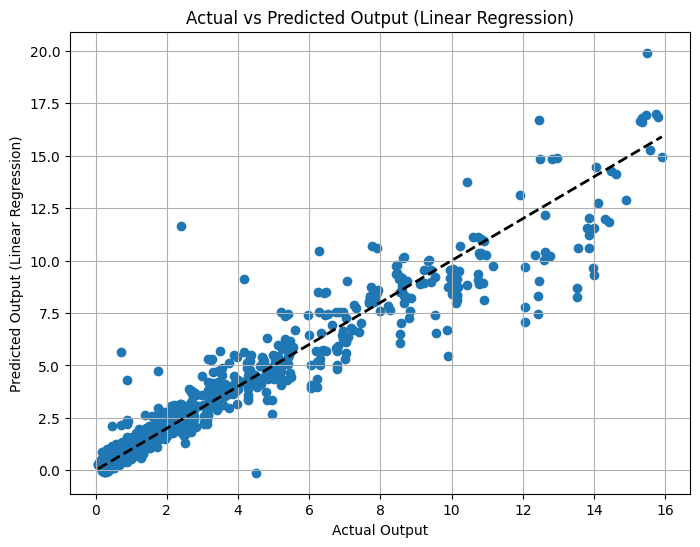

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_eval, y_pred_linear)
plt.xlabel("Actual Output")
plt.ylabel("Predicted Output (Linear Regression)")
plt.title("Actual vs Predicted Output (Linear Regression)")
plt.plot([y_train_eval.min(), y_train_eval.max()], [y_train_eval.min(), y_train_eval.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

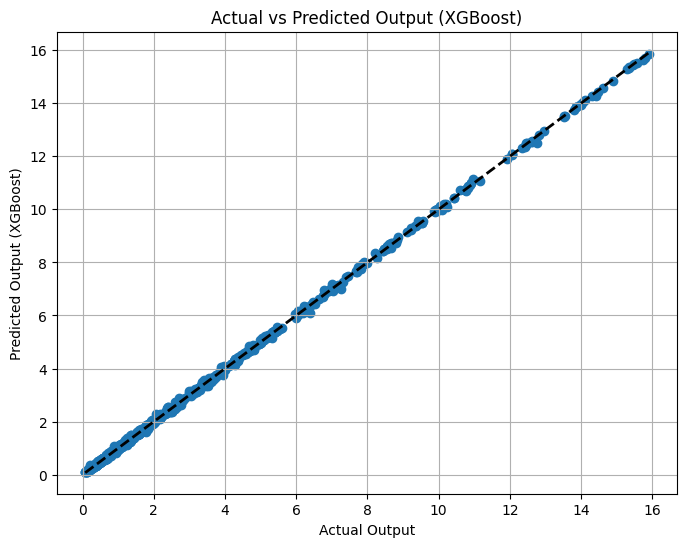

In [63]:
# Plotting for XGBoost Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_train_eval, y_pred_xgb)
plt.xlabel("Actual Output")
plt.ylabel("Predicted Output (XGBoost)")
plt.title("Actual vs Predicted Output (XGBoost)")
plt.plot([y_train_eval.min(), y_train_eval.max()], [y_train_eval.min(), y_train_eval.max()], 'k--', lw=2)
plt.grid(True)
plt.show()

In [64]:
def predict_output_linear(nnz, m, k, n):
    """
    Predicts the output value using the trained Linear Regression model.

    Args:
        nnz (float): The NNZ value.
        m (float): The M value.
        k (float): The K value.
        n (float): The N value.

    Returns:
        float: The predicted output value.
    """
    # Generate all features (original + generated + non-linear)
    original_features_input = np.array([[nnz, m, k, n]])
    generated_nonlinear_features_input = np.array([generate_features(nnz, m, k, n)])
    all_features_input = np.hstack((original_features_input, generated_nonlinear_features_input))

    # Filter features based on which ones were kept during training
    # We need to ensure the prediction uses the exact same feature set and order
    # Access the global features_to_keep_indices
    global features_to_keep_indices
    input_features_filtered = all_features_input[:, features_to_keep_indices]

    # Predict using the trained Linear Regression model
    # Access the global linear_model
    global linear_model
    predicted_value = linear_model.predict(input_features_filtered)

    return predicted_value[0] # model.predict returns an array, return the single value

In [65]:
def predict_output_xgb(nnz, m, k, n):
    """
    Predicts the output value using the trained XGBoost Regression model.

    Args:
        nnz (float): The NNZ value.
        m (float): The M value.
        k (float): The K value.
        n (float): The N value.

    Returns:
        float: The predicted output value.
    """
    # Generate all features (original + generated + non-linear)
    original_features_input = np.array([[nnz, m, k, n]])
    generated_nonlinear_features_input = np.array([generate_features(nnz, m, k, n)])
    all_features_input = np.hstack((original_features_input, generated_nonlinear_features_input))

    # Filter features based on which ones were kept during training
    # We need to ensure the prediction uses the exact same feature set and order
    # Access the global features_to_keep_indices
    global features_to_keep_indices
    input_features_filtered = all_features_input[:, features_to_keep_indices]

    # Predict using the trained XGBoost model
    # Access the global xgb_model
    global xgb_model
    predicted_value = xgb_model.predict(input_features_filtered)

    return predicted_value[0] # model.predict returns an array, return the single value

In [66]:
def pad_dimension(dim_value, num_gpus, second_num_gpus=1):
    prod_num_gpus = num_gpus * second_num_gpus
    remainder = dim_value % prod_num_gpus
    return dim_value if remainder == 0 else dim_value + prod_num_gpus - remainder

def predict(N, NNZ, D_list, config):
    total_spmm_time = 0
    for i in range(len(D_list)):
        g0, g1, g2 = config[(i + 2) % 3], config[i % 3], config[(i + 1) % 3]
        # fwd pass
        total_spmm_time += predict_output_linear(NNZ / (g0 * g1),
                                          pad_dimension(N, g0) / g0,
                                          pad_dimension(N, g1) / g1,
                                          pad_dimension(D_list[i], g2, g0) / g2)
        # bwd pass
        total_spmm_time += predict_output_linear(NNZ / (g0 * g1),
                                    pad_dimension(N, g1) / g1,
                                    pad_dimension(N, g0) / g0,
                                    pad_dimension(D_list[i], g2, g0) / g2)
    return total_spmm_time

In [ ]:
# Unseen data from scaling runs
# TODO: get rid of these hardcoded values and just split the spmm_benchmarking.npy data into train and test

num_nodes = [232965, 2449029, 8745542, 14249639, 50912018, 111059956]
num_nnz = [114848857, 126167053, 1317986044, 245036907, 159021338, 1615685872]
d_lists = [[602, 128, 128], [100, 128, 128], [128, 128, 128], [128, 128, 128], [128, 128, 128], [100, 128, 128]]
configs = [[(1, 4, 1), (1, 8, 1), (1, 8, 2), (1, 16, 2), (2, 16, 2), (2, 16, 4)],
           [(1, 1, 4), (4, 1, 2), (2, 4, 2), (2, 8, 2), (2, 8, 4), (4, 8, 4), (4, 16, 4), (4, 16, 8)],
           [(2, 4, 2), (2, 8, 2), (2, 8, 4), (4, 8, 4), (4, 16, 4), (4, 16, 8), (8, 16, 8)],
           [(4, 1, 2), (2, 4, 2), (2, 8, 2), (2, 8, 4), (4, 8, 4), (4, 16, 4), (4, 16, 8), (8, 16, 8)],
           [(2, 8, 4), (4, 8, 4), (4, 16, 4), (4, 16, 8), (8, 16, 8)],
           [(4, 8, 2), (4, 16, 2), (4, 16, 4), (8, 16, 4), (8, 32, 4), (8, 32, 8)]]

reddit_scaling = [122.44616666666667, 54.96283333333334, 27.58724999999999, 21.20254166666667, 10.498666666666667, 6.076374999999999]
products_scaling = [97.255, 52.669, 26.924, 19.825, 11.098, 6.45, 4.665, 2.941]
protein_scaling = [287.2307916666668, 203.82625000000002, 116.32229166666664, 64.73058333333333, 48.51004166666665, 29.603499999999997, 17.617083333333348]
amazon_scaling = [141.97958333333332, 78.31474999999995, 57.71770833333335, 36.73366666666669, 20.80600000000001, 16.65366666666668, 12.220500000000015, 7.563583333333327]
europe_osm_scaling = [39.59, 23.89, 19.607, 13.502, 8.914]
papers_scaling = [195.44, 155.86, 90.157, 56.336, 46.515, 28.087]

scaling = [reddit_scaling, products_scaling, protein_scaling, amazon_scaling, europe_osm_scaling, papers_scaling]

actual_times, predicted_times = [], []

"""
for i in range(len(scaling)):
    actual_times.extend(scaling[i])

for i in range(len(scaling)):
    for j in range(len(scaling[i])):
        predicted_times.append(predict(num_nodes[i], num_nnz[i], d_lists[i], configs[i][j]))
"""

'\nfor i in range(len(scaling)):\n    actual_times.extend(scaling[i])\n\nfor i in range(len(scaling)):\n    for j in range(len(scaling[i])):\n        predicted_times.append(predict(num_nodes[i], num_nnz[i], d_lists[i], configs[i][j]))\n'

In [68]:
products_configs = [(4, 4, 4), (4, 2, 8), (8, 2, 4), (2, 4, 8), (8, 4, 2), (2, 8, 4), (4, 8, 2), (8, 1, 8),
                    (2, 2, 16), (16, 2, 2), (1, 8, 8), (8, 8, 1), (2, 16, 2), (4, 1, 16), (16, 1, 4), (1, 4, 16),
                    (16, 4, 1), (1, 16, 4), (4, 16, 1), (2, 1, 32), (32, 1, 2), (1, 2, 32), (32, 2, 1), (1, 32, 2),
                    (2, 32, 1), (1, 1, 64), (64, 1, 1), (1, 64, 1)]

actual_times.extend([9.844275, 11.2065375, 11.231362500000001, 11.181750000000001, 11.328512499999999, 11.3051625, 11.1846, 13.344012500000002, 15.5136875, 15.3983125, 13.534899999999999, 13.5412375, 15.386687500000003, 15.863400000000002, 15.94255, 16.0544875, 16.1692375, 15.939874999999997, 16.09005, 24.905112499999998, 25.141712499999997, 25.1828125, 25.171687499999997, 25.094775000000002, 25.178462500000002, 43.09158749999999, 43.449012499999995, 43.47068750000001])
actual_times = np.array(actual_times)

config_to_time = {}

for config in products_configs:
    predicted_times.append(predict(2449029, 126167053, [100, 128, 128], config))
    config_to_time[config] = predicted_times[-1]

In [69]:
config_to_time

{(4, 4, 4): 9.68238743756027,
 (4, 2, 8): 11.397895809461668,
 (8, 2, 4): 11.344114838251171,
 (2, 4, 8): 11.505457751882663,
 (8, 4, 2): 11.355743846677028,
 (2, 8, 4): 11.505457751882664,
 (4, 8, 2): 11.421153763993871,
 (8, 1, 8): 14.392689992883653,
 (2, 2, 16): 16.12541514013396,
 (16, 2, 2): 15.896480390416848,
 (1, 8, 8): 14.57729084863307,
 (8, 8, 1): 14.433391447733403,
 (2, 16, 2): 16.12541514013396,
 (4, 1, 16): 17.468285892889476,
 (16, 1, 4): 17.36435645844969,
 (1, 4, 16): 17.606858472142523,
 (16, 4, 1): 17.384707354521808,
 (1, 16, 4): 17.606858472142523,
 (4, 16, 1): 17.526430814209217,
 (2, 1, 32): 27.623468163354797,
 (32, 1, 2): 27.285996373576936,
 (1, 2, 32): 27.6234681633548,
 (32, 2, 1): 27.29278009315222,
 (1, 32, 2): 27.6234681633548,
 (2, 32, 1): 27.6234681633548,
 (1, 1, 64): 46.908943936684146,
 (64, 1, 1): 46.361182016891206,
 (1, 64, 1): 46.908943936684146}

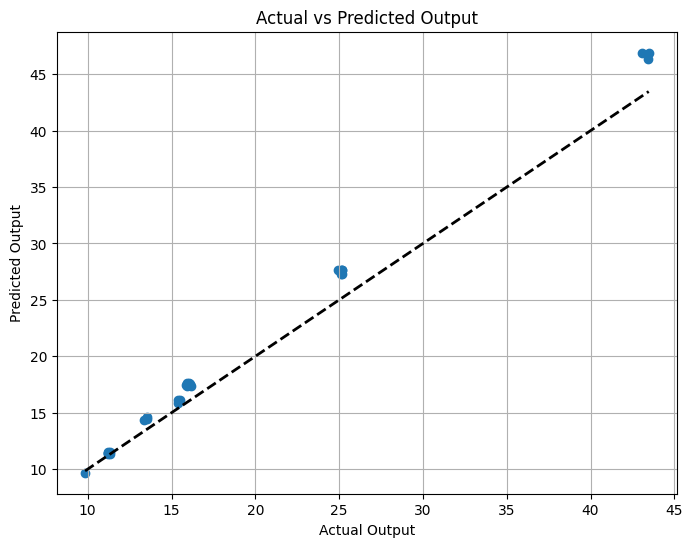

In [70]:
# Plotting Predicted vs Actual values
plt.figure(figsize=(8, 6)) # Set the figure size
plt.scatter(actual_times, predicted_times) # Create a scatter plot of actual vs predicted
plt.xlabel("Actual Output") # Label the x-axis
plt.ylabel("Predicted Output") # Label the y-axis
plt.title("Actual vs Predicted Output") # Add a title
plt.plot([actual_times.min(), actual_times.max()], [actual_times.min(), actual_times.max()], 'k--', lw=2) # Add a diagonal line
plt.grid(True) # Add a grid
plt.show() # Display the plot